# Image Classification with CNN for Malaria Data

*Projede amaç, hücre görüntülerini kullanarak malarya enfeksiyonunu tespit eden sınıflandırma modelleri geliştirmektir. İlk olarak kendi CNN modelimizi geliştirecek, ardından VGG16, VGG19, ResNet50 gibi önceden eğitilmiş modellerle (transfer learning) performanslarını karşılaştıracağız.*

### *İmport Libraries*

In [17]:
import os                  # Dosya ve dizin işlemleri için
import random              # Rastgele seçimler yapmak için
import warnings            # Uyarı mesajlarını yönetmek için
warnings.filterwarnings('ignore') # Tüm uyarı mesajlarını görmezden gelmek için filterwarnings ile 'ignore' ayarını yapıyoruz

import numpy as np         # Sayısal hesaplamalar ve matris işlemleri
import pandas as pd        # Veri analizi ve tablo işlemleri
import cv2                 # Görüntü işleme ve video/frame işlemleri
import kagglehub           # Kaggle veri setlerini kolayca çekmek için
import random

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split  # Veriyi eğitim/test setlerine ayırmak için

from tensorflow.keras.models import Model            # Keras Functional API model tanımı
from tensorflow.keras.layers import Flatten, Dense   # Katmanlar: Flatten ve tam bağlantılı Dense
from tensorflow.keras.applications import VGG16      # Önceden eğitilmiş VGG16 modeli
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)
from tensorflow.keras.layers import Input

### *İmport Data*

In [18]:
import pathlib
path = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"
data_dir = pathlib.Path(path).with_suffix('')

In [19]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

27558


In [20]:
uninfected = list(data_dir.glob("Uninfected/*"))
parasitized = list(data_dir.glob("Parasitized/*"))
print("Number of uninfected cells", len(uninfected))
print("Number of uninfected cells", len(parasitized))

Number of uninfected cells 13780
Number of uninfected cells 13780


### *Displaying some examples*

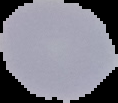

In [21]:
PIL.Image.open(uninfected[1])

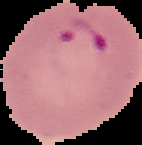

In [22]:
PIL.Image.open(parasitized[1])

In [23]:
batch_size = 32
img_height = 170
img_width = 170

In [24]:
image_gen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.3,
    rescale = 1/255
)

In [25]:
training_data = image_gen.flow_from_directory(
    data_dir,
    subset = "training",
    class_mode="binary",
    target_size = (img_width, img_height),
    batch_size = batch_size
)

validation_data = image_gen.flow_from_directory(
    data_dir,
    subset = "validation",
    class_mode="binary",
    target_size = (img_width, img_height),
    batch_size = batch_size
)

Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


### *Classification*

In [26]:
# Sequential model oluşturuyoruz, katman katman model ekleyebileceğiz
model = Sequential()

# Modelin giriş katmanını tanımlıyoruz
# Girdi boyutu: 170x170 piksel, 3 renk kanalı (RGB)
model.add(Input(shape=(170, 170, 3)))

# 1. Convolution (evrişim) katmanı
# 32 filtre, 3x3 boyutunda, aktivasyon fonksiyonu ReLU
# Görüntüden özellikler çıkarır
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

# 1. MaxPooling katmanı
# 2x2 boyutunda, uzaysal boyutları küçültür ve hesaplamayı azaltır
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2. Convolution katmanı
# 64 filtre, 3x3 boyutunda, aktivasyon fonksiyonu ReLU
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# 2. MaxPooling katmanı
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten katmanı
# Çok boyutlu veriyi tek boyuta indirger, Dense katmanına girdi olarak verir
model.add(Flatten())

# Tam bağlantılı (Dense) katman
# 128 nöron, ReLU aktivasyonu
# Görüntüden çıkarılan özellikleri birleştirir ve öğrenir
model.add(Dense(128, activation='relu'))

# Çıkış katmanı
# 1 nöron, sigmoid aktivasyonu
# Binary classification için 0-1 arasında tahmin verir
model.add(Dense(1, activation='sigmoid'))

# Modeli derliyoruz
# optimizer='adam' → ağırlıkları güncellemek için Adam optimizasyonu
# loss='binary_crossentropy' → binary sınıflandırma için uygun kayıp fonksiyonu
# metrics=['accuracy'] → eğitimi izlerken doğruluk metriğini hesaplar
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# Modeli eğitim verisiyle eğitiyoruz
history = model.fit(
    training_data,
    validation_data=validation_data,
    epochs=20,
    verbose=1             # Eğitim sırasında ilerleme çubuğunu göster
)

Epoch 1/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 265s 431ms/step - accuracy: 0.6394 - loss: 0.7468 - val_accuracy: 0.7728 - val_loss: 0.5334
Epoch 2/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 216s 358ms/step - accuracy: 0.9039 - loss: 0.2683 - val_accuracy: 0.9194 - val_loss: 0.2314
Epoch 3/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 215s 356ms/step - accuracy: 0.9234 - loss: 0.2183 - val_accuracy: 0.9257 - val_loss: 0.1931
Epoch 4/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 213s 353ms/step - accuracy: 0.9373 - loss: 0.1988 - val_accuracy: 0.9342 - val_loss: 0.2027
Epoch 5/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 213s 353ms/step - accuracy: 0.9352 - loss: 0.2011 - val_accuracy: 0.9391 - val_loss: 0.1896
Epoch 6/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 213s 354ms/step - accuracy: 0.9401 - loss: 0.1926 - val_accuracy: 0.9413 - val_loss: 0.1720
Epoch 7/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 211s 351ms/step - accuracy: 0.9458 - loss: 0.1789 - val_accuracy: 0.9423 - val_loss: 0.1679
Epoch 8/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 214s 356ms/step - accuracy: 0.9484 -

### *Save the Model*

In [28]:
model.save('cnn_for_malaria_model.h5')
# huggine kaydetmek istiyorsam .h5 ile kaydetmem lazım

## *Transfer Learning*

### *İmport*

In [29]:
# Keras'ın hazır transfer learning modellerini import ediyoruz
# VGG16 ve ResNet50, önceden ImageNet veri setinde eğitilmiş derin CNN modelleridir
from tensorflow.keras.applications import VGG16, ResNet50

# Görüntü verilerini işlemek ve artırmak (augmentation) için ImageDataGenerator sınıfını import ediyoruz
# Örneğin: döndürme, yakınlaştırma, kaydırma gibi işlemlerle eğitim verisini zenginleştirmek için kullanılır
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### *İmport Another Model - Classification*

In [35]:
# Ana veri klasörünün yolunu belirliyoruz
data_dir = pathlib.Path(path).with_suffix('')

# Modelin girdi boyutunu belirliyoruz (224x224 piksel)
img_width, img_heigth = 224, 224

# Eğitim verisi için ImageDataGenerator oluşturuyoruz
# rescale=1/255 → piksel değerlerini 0-1 aralığına normalize ediyor
# validation_split=0.20 → verinin %20'sini doğrulama için ayırıyor
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.20)

# Eğitim verilerini klasörden okuyup artırma ve hazırlama
train_datagenerator = train_datagen.flow_from_directory(
    directory=data_dir,              # Ana veri klasörü
    target_size=(img_width,img_heigth),  # Görüntüleri 224x224 boyutuna getir
    class_mode='binary',             # Binary sınıflandırma
    subset='training'                # Eğitim verisi olarak ayır
)

# Test/verifikasyon verilerini hazırlıyoruz
test_datagen = ImageDataGenerator(rescale=1/255)

# Doğrulama verilerini klasörden alıyoruz
test_datagenerator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(img_width,img_heigth),
    class_mode='binary',
    subset='validation'              # Doğrulama seti
)

# Önceden eğitilmiş VGG16 modelini yükle
# weights='imagenet' → ImageNet üzerinde önceden eğitilmiş ağırlıklar
# include_top=False → son sınıflandırma katmanını dahil etme (kendi katmanlarımızı ekleyeceğiz)
base_model = VGG16(weights='imagenet', input_shape=(img_width,img_heigth,3), include_top=False)

# Yeni bir Sequential model oluşturuyoruz
model = Sequential()
model.add(base_model)  # Önceden eğitilmiş VGG16 tabanını ekliyoruz

# VGG16 tabanındaki tüm katmanları donduruyoruz, yani eğitim sırasında güncellenmeyecek
for layer in base_model.layers:
    layer.trainable = False

# Kendi üst katmanlarımızı ekliyoruz
model.add(Flatten())            # Çok boyutlu özellik haritasını tek boyuta çevir
model.add(Dense(1024, activation='relu'))  # Fully connected katman, öğrenilen özellikleri birleştir
model.add(Dense(1, activation='sigmoid'))  # Çıkış katmanı, binary sınıflandırma

# Modeli derliyoruz
model.compile(
    optimizer='adam',                 # Ağırlıkları güncellemek için Adam optimizasyonu
    loss='binary_crossentropy',       # Binary sınıflandırma kayıp fonksiyonu
    metrics=['accuracy']              # Eğitim ve doğrulama sırasında doğruluk metriğini takip et
)

# Modeli eğitim verisiyle eğitiyoruz ve doğrulama verisiyle test ediyoruz
# epochs=10 → veri üzerinden 10 kez geçiyoruz
model.fit(
    train_datagenerator,
    epochs=10,
    validation_data=test_datagenerator
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 168s 223ms/step - accuracy: 0.8311 - loss: 0.6962 - val_accuracy: 0.9044 - val_loss: 0.2242
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 150s 217ms/step - accuracy: 0.9279 - loss: 0.1944 - val_accuracy: 0.8897 - val_loss: 0.2990
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 150s 217ms/step - accuracy: 0.9288 - loss: 0.1820 - val_accuracy: 0.9238 - val_loss: 0.1905
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 150s 217ms/step - accuracy: 0.9449 - loss: 0.1452 - val_accuracy: 0.9207 - val_loss: 0.2095
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 150s 218ms/step - accuracy: 0.9497 - loss: 0.1366 - val_accuracy: 0.9211 - val_loss: 0.1958
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 150s 217ms/step - accuracy: 0.9544 - loss: 0.1263 - val_accuracy: 0.9192 - val_loss: 0.2036
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 150s 217ms/step - accuracy: 0.95

### *Save the Transfer Learning Model*

In [36]:
model.save('malaria.TL.h5')